In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!ls

gdrive	sample_data


In [3]:
%%capture
!pip install timm

In [4]:
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 30.4 MB/s 
     |████████████████████████████████| 48.3 MB 1.5 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [5]:
!sudo apt-get install python3-opencv

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-numpy python3-opencv
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,477 kB of archives.
After this operation, 13.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python3-opencv amd64 3.2.0+dfsg-4ubuntu0.1 [534 kB]
Fetched 2,477 kB in 2s (1,072 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog bas

In [6]:
!pip uninstall opencv-contrib-python -y
#!pip uninstall opencv-python

Found existing installation: opencv-contrib-python 4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30


In [7]:
!pip install opencv-contrib-python
!pip3 install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.1 MB 42 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!rm -rf .kaggle

In [9]:
%cd /root/
!mkdir -p ~/.kaggle
 

/root


In [10]:
%cd .kaggle


/root/.kaggle


In [11]:
%cd /root/.kaggle

/root/.kaggle


In [12]:
!pwd

/root/.kaggle


In [14]:
cp /content/gdrive/MyDrive/w251/kaggle.json .

In [15]:
%cd /content/gdrive/MyDrive/w251


/content/gdrive/MyDrive/w251


In [16]:
!ls

HW7.ipynb  kaggle.json


In [17]:
!mkdir bird-watch-summer-2022

In [18]:
%cd bird-watch-summer-2022

/content/gdrive/MyDrive/w251/bird-watch-summer-2022


In [20]:
%cd /content/gdrive/MyDrive/w251/bird-watch-summer-2022/

/content/gdrive/MyDrive/w251/bird-watch-summer-2022


In [21]:
!kaggle competitions download -c bird-watch-summer-2022

100% 870M/870M [00:28<00:00, 38.0MB/s]
100% 870M/870M [00:28<00:00, 32.2MB/s]


In [22]:
!pwd

/content/gdrive/MyDrive/w251/bird-watch-summer-2022


In [23]:
!ls

bird-watch-summer-2022.zip


In [24]:
!unzip bird-watch-summer-2022.zip >> log.txt

In [25]:
!pwd

/content/gdrive/MyDrive/w251/bird-watch-summer-2022


In [1]:
import time
from tqdm import tqdm_notebook as tqdm
#import tqdm.notebook import tqdm
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
import timm
import warnings
warnings.filterwarnings('ignore')

In [2]:
class args:
    lr = 0.001
    epochs = 25
    batch_size = 96
    num_workers = 8
    folds = 5

In [3]:
%cd /content/gdrive/MyDrive/w251/bird-watch-summer-2022

/content/gdrive/MyDrive/w251/bird-watch-summer-2022


In [4]:
!ls

bird-watch-summer-2022.zip  metadata.csv	   test      train
log.txt			    sample_submission.csv  test.csv  train.csv


In [5]:
alldf = pd.read_csv('/content/gdrive/MyDrive/w251/bird-watch-summer-2022/train.csv')
# Split the training dataset into a training and a validation
valdf = alldf[::args.folds]
trndf = alldf[~alldf.filename.isin(valdf.filename)]
# Load our test data
tstdf = pd.read_csv('/content/gdrive/MyDrive/w251/bird-watch-summer-2022/test.csv')
metadf = pd.read_csv('/content/gdrive/MyDrive/w251/bird-watch-summer-2022/metadata.csv')
metadf = metadf.set_index('label')
print(f'File shapes -- train : {trndf.shape}, valid : {valdf.shape}, test : {tstdf.shape}')
trndf.head()

File shapes -- train : (26379, 2), valid : (6595, 2), test : (8244, 1)


,filename,label
1,train/bb99f4bea973.jpg,147
2,train/50923ceb3ffd.jpg,147
3,train/f9fc3c6da5d7.jpg,147
4,train/dfe8cb1855fe.jpg,147
6,train/4fe53a096533.jpg,147


In [5]:
!pwd

/content/gdrive/MyDrive/w251/bird-watch-summer-2022


In [ ]:
#!unzip bird-watch-spring-2022.zip >> log.txt

In [6]:
imgnetmeans = [0.22363983, 0.18190407, 0.2523437 ]
imgnetstds = [0.32451536, 0.2956294,  0.31335256]
# Using albumentations, check some examples here : https://albumentations.readthedocs.io/en/latest/examples.html 
def trntransforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Transpose(p=0.5),
        ToTensorV2(),
        ])

def tsttransforms():
    return A.Compose([
        ToTensorV2(),
    ])

class BirdDataset(Dataset):
    def __init__(self, df, mode, transform=None):
        self.data = df
        self.img_dir = '/content/gdrive/MyDrive/w251/bird-watch-summer-2022'
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        fname = self.data.iloc[idx]['filename']
        img_path = f'{self.img_dir}/{fname}'
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image = image)['image']
        image = image.float() / 255.
        label = -1 if self.mode=='test' else self.data.iloc[idx]['label']
        
        return image, label

In [7]:
# Define our dataset
trndataset = BirdDataset(trndf, 'train', trntransforms())
valdataset = BirdDataset(valdf, 'valid', tsttransforms())
tstdataset = BirdDataset(tstdf, 'test', tsttransforms())

Species : KOOKABURRA


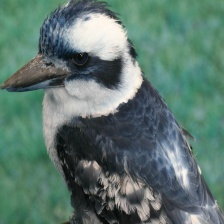

In [8]:
# Test the dataset
img, label = next(iter(trndataset))
species = metadf.loc[label]['name']
print(f'Species : {species}')
#Image.fromarray(img)
imgviz = (img * 255).transpose(0, 2).numpy().astype(np.uint8)
Image.fromarray(imgviz)

In [9]:
loaderargs = {'num_workers' : args.num_workers, 'batch_size':args.batch_size, 'pin_memory': False, 'drop_last': False}
trnloader = DataLoader(trndataset, shuffle = True, **loaderargs)
valloader = DataLoader(valdataset, shuffle = False, **loaderargs)
tstloader = DataLoader(tstdataset, shuffle = False, **loaderargs)

In [10]:
import torch.nn.functional as F
class LabelSmoothingCrossEntropy(torch.nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy, self).__init__()
    def forward(self, x, target, smoothing=0.1):
        confidence = 1. - smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + smoothing * smooth_loss
        return loss.mean()

In [11]:
criterion = LabelSmoothingCrossEntropy()
#loss = criterion(outputs, targets)
#loss.backward()
#optimizer.step()

In [12]:
# creates efficientnet-b0 architecture
device = torch.device("cuda:0")
model = timm.create_model('efficientnet_b2', pretrained = True)
#model = timm.create_model('tv_densenet121', pretrained = True)
 
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
# Loss function
#criterion = torch.nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=10)
#num_epochs = args.epochs

from timm.scheduler.cosine_lr import CosineLRScheduler

num_epochs = args.epochs
n_warmup_epochs = 4
n_steps = len(trnloader)
scheduler = CosineLRScheduler(optimizer, t_initial= n_steps * num_epochs + 1,
                             lr_min=0.00001, warmup_lr_init=0.00001, 
                             warmup_t= n_steps * n_warmup_epochs + 1)



In [13]:

lrls = []
global_step = 0

since = time.time()
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    scheduler.step(global_step)
    global_step+=1 
    lrls.append(optimizer.param_groups[0]['lr'])
    model.train()
    running_loss = 0.0
    tk0 = tqdm(trnloader, total=int(len(trnloader)))
    for step, batch in enumerate(tk0):
        inputs = batch[0].to(device, dtype=torch.float)
        labels = batch[1].to(device).long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
 #       loss = LabelSmoothingLoss(criterion(outputs, labels))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        tk0.set_postfix(train_loss=(running_loss / (step+1)))
        
    valpreds = []
    model.eval()
    running_loss = 0.0
    tkval = tqdm(valloader, total=int(len(valloader)))
    for step, batch in enumerate(tkval):
        inputs = batch[0].to(device, dtype=torch.float)
        labels = batch[1].to(device).long()
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        valpreds .append(outputs)
        running_loss += loss.item()
        tkval.set_postfix(valid_loss=(running_loss / (step+1)))
    preds = torch.cat(valpreds).argmax(1).detach().cpu().numpy()
    print(f'Valid accuracy {(valdf.label.values == preds).mean():.4f}')

Epoch 0/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.0126
Epoch 1/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.0428
Epoch 2/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.1483
Epoch 3/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.3365
Epoch 4/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.5372
Epoch 5/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.6942
Epoch 6/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.7841
Epoch 7/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.8328
Epoch 8/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.8573
Epoch 9/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.8766
Epoch 10/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.8902
Epoch 11/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9020
Epoch 12/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9108
Epoch 13/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9184
Epoch 14/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9193
Epoch 15/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9255
Epoch 16/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9310
Epoch 17/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9318
Epoch 18/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9346
Epoch 19/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9345
Epoch 20/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9389
Epoch 21/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9424
Epoch 22/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9431
Epoch 23/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9440
Epoch 24/24


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Valid accuracy 0.9448


In [ ]:
# Submit 
tstpreds = []
tktst = tqdm(tstloader, total=int(len(tstloader)))
for step, batch in enumerate(tktst):
    inputs = batch[0].to(device, dtype=torch.float)
    with torch.no_grad():
        outputs = model(inputs)
        tstpreds.append(outputs)
predicted_labels = torch.cat(tstpreds).argmax(1).detach().cpu().numpy()
tstdf['label'] = predicted_labels

  0%|          | 0/86 [00:00<?, ?it/s]

In [ ]:
tstdf.to_csv('submission.csv', index = False)